<a href="https://colab.research.google.com/github/brendontj/CC-Fraud-Detection/blob/master/cc_fraud_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, mean_absolute_error, accuracy_score, plot_roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from math import sqrt

O conjunto de dados apresenta em suma dados numéricos obtidos após transformação PCA (Principal Component Analysis). Não foi possível obter os dados previamente a esta transformação.

Leitura do dataset de entrada com informações referentes a transações de cartão de crédito.

In [39]:
data = pd.read_csv('creditcard.csv')
print('Quantidade de linhas do dataset {}'.format(data.shape[0]))
data.head()

Quantidade de linhas do dataset 284807


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


- Removemos os registros que apresentam features com valores faltantes
- Removemos a feature "time" por achar que a mesma não é relevante para predizer se uma transação é ou não fraudulenta

In [40]:
df = data.dropna()
df = df.drop(columns="Time")
df['ID']= np.arange(1,len(df.Class)+1)
print('Quantidade de linhas do dataset sem valor Null/NaN/NaT {}'.format(df.shape[0]))
df.head()

Quantidade de linhas do dataset sem valor Null/NaN/NaT 284807


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,ID
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,1
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,2
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,3
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,4
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,5


Particionamos o dataset de entrada em 80% para o conjunto de treino e 20% para o conjunto de teste.

In [41]:
x_train,  x_test, y_train, y_test = train_test_split(df.drop(['ID', 'Class'], axis=1), df['Class'], test_size=0.20, random_state = 0)
print('Dados de treino {}\n'.format(x_train.shape))
print('Dados de teste  {}\n'.format(x_test.shape))

Dados de treino (227845, 29)

Dados de teste  (56962, 29)



In [42]:
df_train = x_train.copy()
df_train['Class'] = y_train
df_test = x_test.copy()
df_test['Class'] = y_test

Descrição estatística do conjunto de treino

In [43]:
df_train.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000
mean,0.002930,-0.000877,-0.001470,0.001131,-0.001714,-0.001035,-0.000411,-0.001360,-0.000018,0.001496,-0.000732,-0.000990,0.000816,0.000992,0.000608,-0.000131,0.000657,-0.000735,0.000312,0.001775,0.000266,0.000300,-0.000276,0.000687,0.000192,-0.000584,-0.000574,-0.000135,88.630203,0.001716
std,1.955265,1.649672,1.515055,1.416360,1.365962,1.326404,1.225317,1.205508,1.099972,1.091091,1.019688,0.997871,0.997318,0.956432,0.915323,0.875836,0.850158,0.837698,0.815065,0.764878,0.737593,0.726705,0.623074,0.605268,0.520835,0.481943,0.401394,0.320750,248.037789,0.041390
min,-46.855047,-63.344698,-33.680984,-5.683171,-42.147898,-23.496714,-43.557242,-73.216718,-13.434066,-24.588262,-4.797473,-18.553697,-5.791881,-19.214325,-4.498945,-14.129855,-25.162799,-9.498746,-7.213527,-23.646890,-34.830382,-10.933144,-44.807735,-2.822684,-10.295397,-2.604551,-22.565679,-11.710896,0.000000,0.000000
25%,-0.919898,-0.599013,-0.894424,-0.847412,-0.693585,-0.769201,-0.553573,-0.209145,-0.644499,-0.534165,-0.763115,-0.407805,-0.649363,-0.424852,-0.583393,-0.468316,-0.483629,-0.499053,-0.456435,-0.211511,-0.228658,-0.543193,-0.161766,-0.354153,-0.316644,-0.327647,-0.070776,-0.052865,5.690000,0.000000
50%,0.021886,0.063972,0.177138,-0.017538,-0.055515,-0.274916,0.039988,0.021545,-0.050353,-0.091912,-0.033716,0.139185,-0.013345,0.050754,0.049506,0.066979,-0.065926,-0.004297,0.004283,-0.062430,-0.028974,0.006970,-0.010914,0.041164,0.017429,-0.052443,0.001091,0.011171,22.000000,0.000000
75%,1.316871,0.802516,1.026049,0.744471,0.610153,0.397215,0.569938,0.325849,0.597788,0.457121,0.739265,0.618081,0.664465,0.493876,0.649587,0.522822,0.400096,0.499689,0.459840,0.133394,0.187107,0.529867,0.147642,0.439916,0.350742,0.240840,0.090529,0.078142,77.600000,0.000000
max,2.451888,22.057729,9.382558,16.875344,34.099309,23.917837,44.054461,20.007208,15.594995,23.745136,12.018913,7.848392,4.569009,10.526766,5.825654,7.059132,9.207059,5.041069,5.572113,39.420904,27.202839,10.503090,22.528412,4.022866,7.519589,3.463246,12.152401,22.620072,19656.530000,1.000000


Descrição estatística do conjunto de teste

In [44]:
df_test.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000
mean,-0.011720,0.003508,0.005881,-0.004524,0.006858,0.004139,0.001644,0.005440,0.000074,-0.005986,0.002927,0.003958,-0.003264,-0.003967,-0.002431,0.000523,-0.002629,0.002940,-0.001246,-0.007101,-0.001065,-0.001201,0.001104,-0.002750,-0.000767,0.002337,0.002295,0.000541,87.227297,0.001773
std,1.972334,1.657848,1.521044,1.413903,1.435957,1.355490,1.283130,1.148643,1.093268,1.079827,1.024805,1.004503,0.987058,0.967199,0.915292,0.877925,0.846048,0.840086,0.809937,0.794620,0.722125,0.721680,0.629978,0.607158,0.523049,0.483359,0.412459,0.365040,258.280642,0.042071
min,-56.407510,-72.715728,-48.325589,-5.600607,-113.743307,-26.160506,-23.189397,-50.943369,-8.630390,-17.141514,-4.568390,-18.683715,-3.835618,-18.049998,-4.391307,-13.303888,-22.883999,-9.287832,-4.353679,-54.497720,-22.665685,-8.483441,-32.828995,-2.836627,-8.696627,-1.855355,-8.878665,-15.430084,0.000000,0.000000
25%,-0.921972,-0.595792,-0.874649,-0.853267,-0.683487,-0.765653,-0.555542,-0.206208,-0.637058,-0.539031,-0.759576,-0.396268,-0.643496,-0.428579,-0.580244,-0.467537,-0.484584,-0.494712,-0.455365,-0.212744,-0.227182,-0.538917,-0.162292,-0.356309,-0.319498,-0.324004,-0.071012,-0.053511,5.460000,0.000000
50%,-0.002761,0.072712,0.191364,-0.028170,-0.050472,-0.271310,0.040576,0.025516,-0.053689,-0.097007,-0.028609,0.143534,-0.014759,0.049965,0.041602,0.063724,-0.064384,-0.001115,0.002028,-0.062617,-0.031747,0.006132,-0.012237,0.040072,0.013137,-0.050965,0.002251,0.011521,21.940000,0.000000
75%,1.309289,0.809015,1.031690,0.739049,0.619408,0.403661,0.572788,0.332808,0.594146,0.440694,0.741010,0.618570,0.652610,0.491192,0.645804,0.524908,0.397842,0.505740,0.454977,0.131808,0.183874,0.524395,0.147643,0.438394,0.350657,0.241285,0.093085,0.078844,76.000000,0.000000
max,2.454930,14.845545,4.079168,16.491217,34.801666,73.301626,120.589494,17.573712,9.272376,15.331742,11.228470,4.406338,7.126883,7.293226,8.877742,17.315112,9.253526,4.295648,5.591971,19.746453,22.579714,7.220158,19.002942,4.584549,5.521140,3.517346,31.612198,33.847808,25691.160000,1.000000


Contagem dos valores de cada classe. 0 indicando uma transação onde não há fraude e 1 indicando uma fraude.

In [45]:
df_train['Class'].value_counts()

0    227454
1       391
Name: Class, dtype: int64

In [46]:
df_test['Class'].value_counts()

0    56861
1      101
Name: Class, dtype: int64

Gráficos com a quantidade de cada classe nos conjuntos de dados

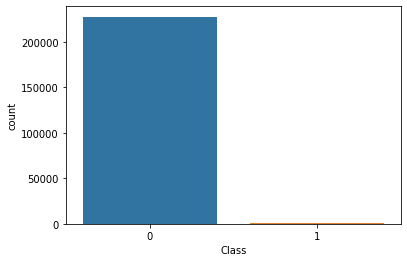

In [47]:
ax = sns.countplot(x="Class", data=df_train)

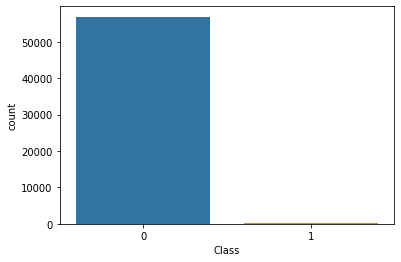

In [48]:
bx = sns.countplot(x="Class", data=df_test)

In [49]:
n_fraudulent_transactions = df_train['Class'].value_counts()[1]
print('Quantidade de transações fraudulentas no dataset de treino ({}) representando um total de ({})% do dataset'.format(n_fraudulent_transactions, (n_fraudulent_transactions/df_train.shape[0])*100))
n_fraudulent_transactions = df_test['Class'].value_counts()[1]
print('Quantidade de transações fraudulentas no dataset de teste ({}) representando um total de ({})% do dataset'.format(n_fraudulent_transactions, (n_fraudulent_transactions/df_test.shape[0])*100))

Quantidade de transações fraudulentas no dataset de treino (391) representando um total de (0.171607891329632)% do dataset
Quantidade de transações fraudulentas no dataset de teste (101) representando um total de (0.1773111899160844)% do dataset


Utilizamos o `mutual_info_classif` para estimar informações através de testes estatísticos, auxiliando na seleção de atributos que possuem forte relacionamento com a variável que estamos tentando prever.

In [50]:
mic = mutual_info_classif(x_train, y_train)
mic

array([0.00223417, 0.00324333, 0.0048859 , 0.00493872, 0.0024805 ,
       0.00235812, 0.00385332, 0.00200889, 0.00420066, 0.00735391,
       0.00683457, 0.00754913, 0.00048603, 0.00796175, 0.00033733,
       0.00614541, 0.00819216, 0.00429184, 0.00147992, 0.00127442,
       0.00256113, 0.0004726 , 0.00081558, 0.00072547, 0.0006311 ,
       0.00054575, 0.00238648, 0.00180494, 0.00145779])

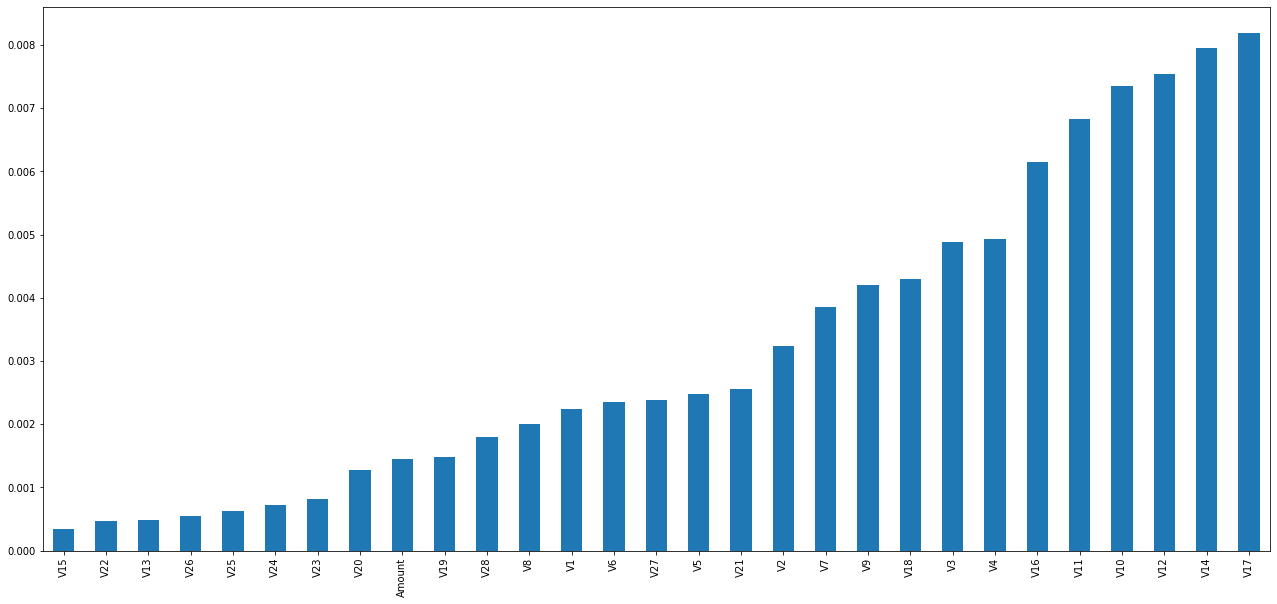

In [51]:
mic = pd.Series(mic)
mic.index = x_train.columns
mic = mic.sort_values(ascending = True)
mic.plot.bar(figsize=(22,10))

Selecionamos as K variáveis que mais se relacionam com a coluna que indica a classificação da transação. `k=22`

In [52]:
selection = SelectKBest(mutual_info_classif, k= 22).fit(x_train, y_train)
X_train = x_train[x_train.columns[selection.get_support()]]
X_test = x_test[x_test.columns[selection.get_support()]]

Função utilizada para gerar as curvas do K fold cross validation

In [53]:
def plot_Kfold_cross_validation_curves(md, x_data, y_data):
  cv = StratifiedKFold(n_splits=5)

  tprs = []
  aucs = []
  mean_fpr = np.linspace(0, 1, 100)

  fig, ax = plt.subplots()
  for i, (train, test) in enumerate(cv.split(x_data, y_data)):
      md.fit(x_data.iloc[train], y_data.iloc[train])
      viz = plot_roc_curve(md, x_data.iloc[test], y_data.iloc[test],
                          name='ROC fold {}'.format(i),
                          alpha=0.3, lw=1, ax=ax)
      interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
      interp_tpr[0] = 0.0
      tprs.append(interp_tpr)
      aucs.append(viz.roc_auc)

  ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
          label='Chance', alpha=.8)

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  mean_auc = auc(mean_fpr, mean_tpr)
  std_auc = np.std(aucs)
  ax.plot(mean_fpr, mean_tpr, color='b',
          label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
          lw=2, alpha=.8)

  std_tpr = np.std(tprs, axis=0)
  tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
  ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                  label=r'$\pm$ 1 std. dev.')

  ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
        title="ROC for K fold cross-validation curves")
  ax.legend(loc="lower right")
  plt.show()

# Random Forest

Utilizaremos a classe padrão do classificador Random Forest, não utilizamos variações na parametrização da classe devido a obtenção de um resultado satisfatório com os parâmetros padrões.  

In [54]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## Treino

Relatório de classificação da predição com o modelo Random forest com o sample de treino

In [55]:
predictions = rf.predict(X_train)
print(classification_report(y_train, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227454
           1       1.00      1.00      1.00       391

    accuracy                           1.00    227845
   macro avg       1.00      1.00      1.00    227845
weighted avg       1.00      1.00      1.00    227845



Matriz de confusão dos valores preditos com o conjunto de treino

In [56]:
pd.crosstab(y_train, predictions, rownames=['Real'],colnames=['Predito'],margins=True)

Predito,0,1,All
Real,,,
0,227454,0,227454
1,1,390,391
All,227455,390,227845


Scores das validações cruzadas

In [57]:
scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
scores

array([0.99958305, 0.99940749, 0.99962694, 0.99956111, 0.99949527])

Media dos scores obtidos das validações cruzadas

In [58]:
scores.mean()

0.9995347714455003

Acurácia das predições com base no conjunto de treino

In [59]:
accuracy_score(y_train, predictions)

0.9999956110513727

Erro absoluto com base no conjunto de treino




In [60]:
e = mean_absolute_error(y_train, predictions)
e

4.388948627356317e-06

Curva ROC

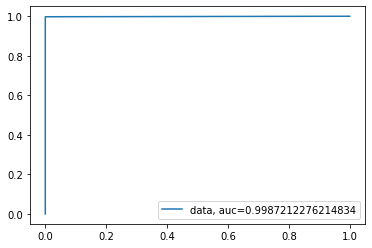

In [61]:
fpr, tpr, _ = roc_curve(y_train, predictions)
roc_auc_scr =  roc_auc_score(y_train, predictions)
plt.plot(fpr,tpr,label="data, auc="+str(roc_auc_scr))
plt.legend(loc=4)
plt.show() 

Curvas da K fold cross-validation

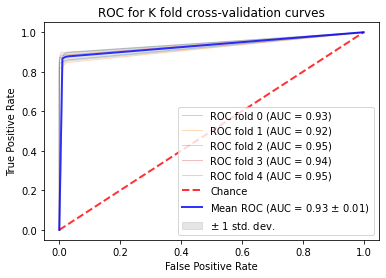

In [62]:
plot_Kfold_cross_validation_curves(rf, X_train, y_train)

## Teste

Predição com o sample de teste

In [63]:
predictions_test = rf.predict(X_test)

Relatório de classificação da predição com o modelo Random forest com o sample de teste



In [64]:
print(classification_report(y_test, predictions_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56861
           1       0.93      0.77      0.84       101

    accuracy                           1.00     56962
   macro avg       0.96      0.89      0.92     56962
weighted avg       1.00      1.00      1.00     56962



Matriz de confusão dos valores preditos com o conjunto de teste

In [65]:
pd.crosstab(y_test, predictions_test, rownames=['Real'],colnames=['Predito'],margins=True) 

Predito,0,1,All
Real,,,
0,56855,6,56861
1,23,78,101
All,56878,84,56962


Validação cruzada utilizando 5 pastas com conjunto de teste

In [66]:
scores = cross_val_score(rf, X_test, predictions_test, cv=5, scoring='accuracy')
scores

array([0.99973668, 0.99964891, 0.99982444, 0.99947331, 0.99982444])

Media dos scores obtidos com o conjunto de teste

In [67]:
scores.mean()

0.9997015557305542

Acurácia do modelo

In [68]:
accuracy_score(y_test, predictions_test)

0.9994908886626171

Mean Absolute Error

In [69]:
e = mean_absolute_error(y_test, predictions_test)
e

0.0005091113373828166

Curva ROC com o conjunto de teste

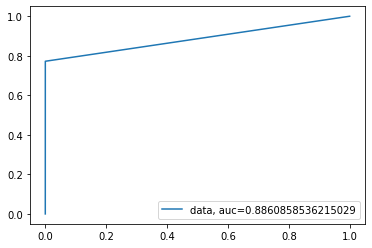

In [70]:
fpr, tpr, _ = roc_curve(y_test, predictions_test)
roc_auc_scr =  roc_auc_score(y_test, predictions_test)
plt.plot(fpr,tpr,label="data, auc="+str(roc_auc_scr))
plt.legend(loc=4)
plt.show()

Curvas da K fold cross-validation com os dados de teste

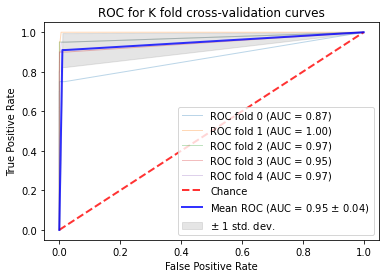

In [71]:
plot_Kfold_cross_validation_curves(rf, X_test, y_test)

# KNN 

Utilizaremos a classe padrão do K Neighbors Classifier, utilizaremos apenas o parâmetro `n_neighbors=3` pois o mesmo demonstrou um aumento na acurácia do modelo. Para descobrir isso executamos `i` execuções com `i` variando de 1 até 25 e a execução com 3 vizinhos mostrou a melhor acurácia.

In [72]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

## Treino

Predição da classificação dos dados de treino com base no modelo treinado

In [74]:
y_pred = knn.predict(X_train)

Relatório de classificação da predição com o modelo K Neighbors classifier com o sample de treino

In [75]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227454
           1       0.96      0.76      0.85       391

    accuracy                           1.00    227845
   macro avg       0.98      0.88      0.92    227845
weighted avg       1.00      1.00      1.00    227845



Matriz de confusão dos valores preditos com o conjunto de treino

In [76]:
pd.crosstab(y_train, y_pred, rownames=['Real'],colnames=['Predito'],margins=True)

Predito,0,1,All
Real,,,
0,227442,12,227454
1,94,297,391
All,227536,309,227845


Scores das validações cruzadas

In [77]:
scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
scores

array([0.9993636 , 0.99927582, 0.99945138, 0.99934166, 0.99912221])

Media dos scores obtidos das validações cruzadas

In [78]:
scores.mean()

0.9993109350655051

Acurácia das predições com base no conjunto de treino

In [79]:
accuracy_score(y_train, y_pred)

0.9995347714455002

Erro absoluto médio

In [80]:
e = mean_absolute_error(y_train, y_pred)
e

0.0004652285544997696

Curva ROC dos dados de treino

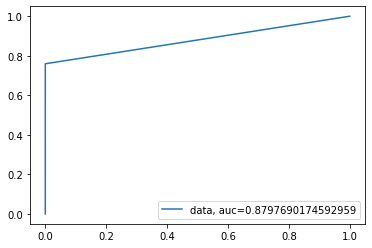

In [81]:
fpr, tpr, _ = roc_curve(y_train, y_pred)
roc_auc_scr =  roc_auc_score(y_train, y_pred)
plt.plot(fpr,tpr,label="data, auc="+str(roc_auc_scr))
plt.legend(loc=4)
plt.show()

Curvas da K fold cross-validation

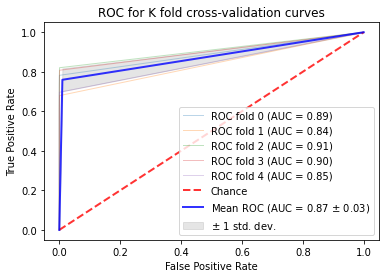

In [82]:
plot_Kfold_cross_validation_curves(knn, X_train, y_train)

## Teste

Predição com base no modelo treinado utilizando o sample de teste

In [83]:
y_pred = knn.predict(X_test)

Relatório de classificação da predição com o modelo KNN com o sample de teste

In [84]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56861
           1       0.92      0.72      0.81       101

    accuracy                           1.00     56962
   macro avg       0.96      0.86      0.91     56962
weighted avg       1.00      1.00      1.00     56962



Matriz de confusão dos valores preditos com o conjunto de teste

In [85]:
pd.crosstab(y_test, y_pred, rownames=['Real'],colnames=['Predito'],margins=True)

Predito,0,1,All
Real,,,
0,56855,6,56861
1,28,73,101
All,56883,79,56962


Scores das validações cruzadas

In [86]:
scores = cross_val_score(knn, X_test, y_test, cv=5, scoring='accuracy')
scores

array([0.99938559, 0.99912227, 0.99894663, 0.99894663, 0.99920997])

Media dos scores obtidos com o conjunto de teste

In [87]:
scores.mean()

0.9991222172075895

Acurácia do modelo com base nos dados preditos do conjunto de teste

In [88]:
accuracy_score(y_test, y_pred)

0.999403110845827

Erro absoluto do modelo com base no conjunto de teste

In [89]:
e = mean_absolute_error(y_test, y_pred)
e

0.0005968891541729574

Curva ROC com o conjunto de teste

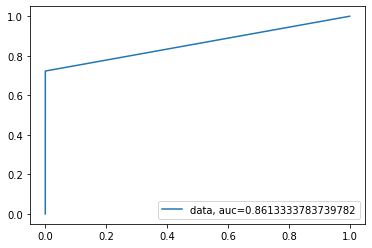

In [90]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc_scr =  roc_auc_score(y_test, y_pred)
plt.plot(fpr,tpr,label="data, auc="+str(roc_auc_scr))
plt.legend(loc=4)
plt.show()

Curvas da K fold cross-validation com os dados de teste

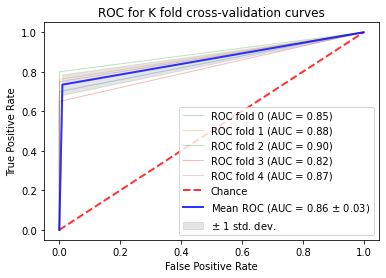

In [91]:
plot_Kfold_cross_validation_curves(knn, X_test, y_test)

# MLPClassifier

Utilizaremos a classe do MLP Classifier com algumas alterações dos parâmetros default, pois principalmente relacionado ao número de iterações acaba fazendo com que o tempo de execução se torne algo muito custoso principalmente para executar as k validações cruzadas. Optamos por diminuir o número de layers como o número de neurônios da rede neural para 2 camadas com 50 neurônios cada e um número máximo de iterações igual a 5. Importante deixar claro que o modelo apresenta uma acurácia superor utizando a parametrização padrão da classe.

In [92]:
clf = MLPClassifier(hidden_layer_sizes=(50,50), max_iter=5, alpha=0.0001,
                     solver='sgd', verbose=10,  random_state=21,tol=0.000000001)

## Treino

Treino e predição com o modelo treinado utilizando o MLP classifier

In [93]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)

Iteration 1, loss = inf
Iteration 2, loss = 0.02712378
Iteration 3, loss = inf
Iteration 4, loss = 0.01661020
Iteration 5, loss = 0.01060315


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Relatório de classificação da predição com o modelo MLPClassifier com o sample de treino

In [94]:
 print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227454
           1       0.87      0.64      0.74       391

    accuracy                           1.00    227845
   macro avg       0.93      0.82      0.87    227845
weighted avg       1.00      1.00      1.00    227845



Matriz de confusão dos valores preditos com o conjunto de treino

In [95]:
pd.crosstab(y_train, y_pred, rownames=['Real'],colnames=['Predito'],margins=True)

Predito,0,1,All
Real,,,
0,227416,38,227454
1,141,250,391
All,227557,288,227845


Scores das validações cruzadas com conjunto de treino


In [96]:
scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
scores

Iteration 1, loss = inf
Iteration 2, loss = 0.02722532
Iteration 3, loss = 0.02695025
Iteration 4, loss = 0.02307299
Iteration 5, loss = 0.01372564


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = inf
Iteration 2, loss = 0.02913047
Iteration 3, loss = 0.03468142
Iteration 4, loss = 0.01834889
Iteration 5, loss = 0.01344923


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = inf
Iteration 2, loss = 0.02834564
Iteration 3, loss = inf
Iteration 4, loss = 0.02769228
Iteration 5, loss = 0.01786017


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = inf
Iteration 2, loss = 0.02960014
Iteration 3, loss = inf
Iteration 4, loss = 0.01987128
Iteration 5, loss = 0.01891146


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = inf
Iteration 2, loss = 0.03324739
Iteration 3, loss = inf
Iteration 4, loss = 0.01918058
Iteration 5, loss = 0.01250826


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


array([0.99918804, 0.99929777, 0.99881498, 0.99899054, 0.99870526])

Media dos scores obtidos das validações cruzadas

In [97]:
scores.mean()

0.9989993197129629

Acurácia das predições com base no conjunto de treino

In [98]:
accuracy_score(y_train, y_pred)

0.9992143781957032

Erro absoluto com base no conjunto de treino

In [99]:
e = mean_absolute_error(y_train, y_pred)
e

0.0007856218042967807

Curva ROC com os dados de treino

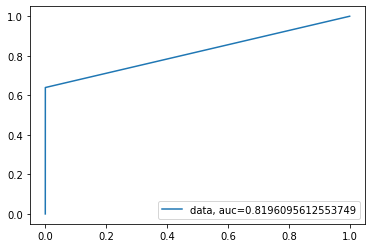

In [100]:
fpr, tpr, _ = roc_curve(y_train, y_pred)
roc_auc_scr =  roc_auc_score(y_train, y_pred)
plt.plot(fpr,tpr,label="data, auc="+str(roc_auc_scr))
plt.legend(loc=4)
plt.show()

Curvas da K fold cross-validation com os dados de treino

Iteration 1, loss = inf
Iteration 2, loss = 0.02722532
Iteration 3, loss = 0.02695025
Iteration 4, loss = 0.02307299
Iteration 5, loss = 0.01372564


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = inf
Iteration 2, loss = 0.02913047
Iteration 3, loss = 0.03468142
Iteration 4, loss = 0.01834889
Iteration 5, loss = 0.01344923


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = inf
Iteration 2, loss = 0.02834564
Iteration 3, loss = inf
Iteration 4, loss = 0.02769228
Iteration 5, loss = 0.01786017


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = inf
Iteration 2, loss = 0.02960014
Iteration 3, loss = inf
Iteration 4, loss = 0.01987128
Iteration 5, loss = 0.01891146


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = inf
Iteration 2, loss = 0.03324739
Iteration 3, loss = inf
Iteration 4, loss = 0.01918058
Iteration 5, loss = 0.01250826


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


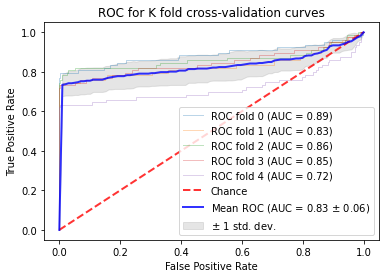

In [101]:
plot_Kfold_cross_validation_curves(clf, X_train, y_train)

## Teste

Predição dos dados de teste com o modelo treinado utilizando o MLP classifier

In [102]:
y_pred = clf.predict(X_test)

Relatório de classificação da predição com o modelo MLPClassifier com o sample de teste

In [103]:
 print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56861
           1       0.88      0.56      0.69       101

    accuracy                           1.00     56962
   macro avg       0.94      0.78      0.84     56962
weighted avg       1.00      1.00      1.00     56962




Matriz de confusão dos valores preditos com o conjunto de teste

In [104]:
pd.crosstab(y_test, y_pred, rownames=['Real'],colnames=['Predito'],margins=True)

Predito,0,1,All
Real,,,
0,56853,8,56861
1,44,57,101
All,56897,65,56962


Scores das validações cruzadas com conjunto de treino

In [105]:
scores = cross_val_score(clf, X_test, y_test, cv=5, scoring='accuracy')
scores

Iteration 1, loss = inf
Iteration 2, loss = 0.10979617
Iteration 3, loss = 0.07809046
Iteration 4, loss = 0.05709109
Iteration 5, loss = 0.04128277


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = inf
Iteration 2, loss = 0.10426688
Iteration 3, loss = 0.07710955
Iteration 4, loss = 0.05767491
Iteration 5, loss = 0.04334860


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = inf
Iteration 2, loss = 0.10734112
Iteration 3, loss = 0.07366163
Iteration 4, loss = 0.05507909
Iteration 5, loss = 0.03982645


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = inf
Iteration 2, loss = 0.11081528
Iteration 3, loss = 0.07684522
Iteration 4, loss = 0.05440205
Iteration 5, loss = 0.03938074


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = inf
Iteration 2, loss = 0.10059844
Iteration 3, loss = 0.07369080
Iteration 4, loss = 0.05428945
Iteration 5, loss = 0.03891028


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


array([0.99877118, 0.99850786, 0.99868329, 0.99885885, 0.99868329])

Média dos scores obtidos das k validações cruzadas

In [106]:
scores.mean()

0.9987008904664505

Acurácia das predições com base no conjunto de teste

In [107]:
accuracy_score(y_test, y_pred)

0.9990871107053826

Erro absoluto com base no conjunto de teste

In [108]:
e = mean_absolute_error(y_test, y_pred)
e

0.0009128892946174643

Curva ROC utilizando os dados de teste

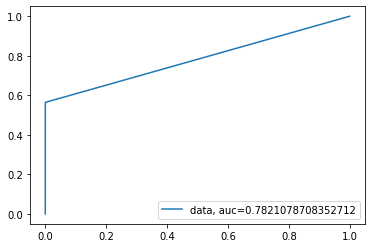

In [109]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc_scr =  roc_auc_score(y_test, y_pred)
plt.plot(fpr,tpr,label="data, auc="+str(roc_auc_scr))
plt.legend(loc=4)
plt.show()

Curvas da K fold cross-validation com os dados de teste

Iteration 1, loss = inf
Iteration 2, loss = 0.10979617
Iteration 3, loss = 0.07809046
Iteration 4, loss = 0.05709109
Iteration 5, loss = 0.04128277


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = inf
Iteration 2, loss = 0.10426688
Iteration 3, loss = 0.07710955
Iteration 4, loss = 0.05767491
Iteration 5, loss = 0.04334860


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = inf
Iteration 2, loss = 0.10734112
Iteration 3, loss = 0.07366163
Iteration 4, loss = 0.05507909
Iteration 5, loss = 0.03982645


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = inf
Iteration 2, loss = 0.11081528
Iteration 3, loss = 0.07684522
Iteration 4, loss = 0.05440205
Iteration 5, loss = 0.03938074


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = inf
Iteration 2, loss = 0.10059844
Iteration 3, loss = 0.07369080
Iteration 4, loss = 0.05428945
Iteration 5, loss = 0.03891028


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


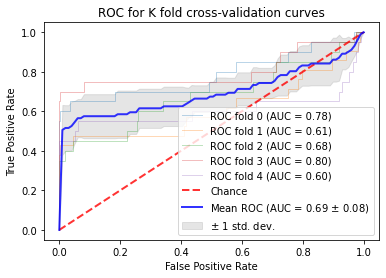

In [110]:
plot_Kfold_cross_validation_curves(clf, X_test, y_test)

É uma pena para a execução do trabalho com base nesse tema não ter o dataset pré processamento para identificar um possível overfit nos modelos criados, haja vista a grande acurácia apresentada. Apesar da incógnita perando as features dos dados pré processamento podemos concluir que o objetivo foi alcançado com sucesso. Podemos fazer esta afirmação olhando para as taxas de falso positivo e falso negativo já que os dados em si apresentam em ampla maioria registros de transações não fraudulentas, logo o peso de marcar uma transação como fraudulenda ou não sem que a mesma tenha realmente esta classificação adquire um peso maior.